In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from rnnEstimator import RnnEstimator

#import penalization class
from linearRewarder import LinearRewarder
from thresholdRewarder import ThresholdRewarder

from myUtils.sequences_treatment import *

# import environment class
from optimalIntermittency import OptimalIntermittency

# import deer classes
from deer.learning_algos.q_net_keras import MyQNetwork
from deer.agent import NeuralAgent
import deer.experiment.base_controllers as bc

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense (Dense)                (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
240/240 - 2s - loss: 0.1109 - val_loss: 0.0861
Epoch 2/10
240/240 - 1s - loss: 0.0785 - val_loss: 0.0683
Epoch 3/10
240/240 - 1s - loss: 0.0572 - val_loss: 0.0414
Epoch 4/10
240/240 - 1s - loss: 0.0289 - val_loss: 0.0216
Epoch 5/10
240/240 - 1s - loss: 0.0207 - val_loss: 0.0191
Epoch 6/10
240/240 - 1s - loss: 0.0195 - val_loss: 0.0190
Epoch 7/10
240/240 - 1s - loss: 0.01

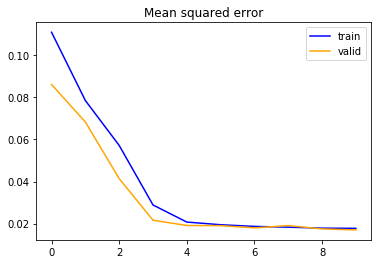

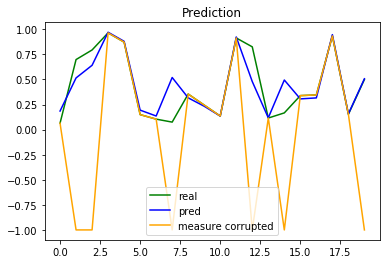

In [3]:
# construct and train a Sequential RNN model with keras
numberSamples=300
T_train=20
generatorType='random01'

# generate sequences for training
(obj_train,obs_train)=generateSequence(T_train,numberSamples=numberSamples,generatorType=generatorType)
sigma=randomSigma(T_train,numberSamples=numberSamples,p0=0.2)
obs_train_corrupted=corruptSequence_outOfRange(obs_train,sigma)

n_dim_obs=np.shape(obs_train_corrupted)[2]
n_dim_obj=np.shape(obj_train)[2]

model=Sequential()
model.add(LSTM(20,input_shape=(None,n_dim_obs),return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(Dense(n_dim_obj,activation=None))

model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

# train the RNN
history=model.fit(x=obs_train_corrupted,y=obj_train,batch_size=1,epochs=10,validation_split=0.2,verbose=2)

# plot loss
plotRNNresults(history)

# plot prediction
indToPlot=0
obj_train_pred=model.predict(obs_train_corrupted[indToPlot:(indToPlot+1),:,:])

pyplot.title('Prediction')
pyplot.plot(obj_train[indToPlot,:,0], color='green', label='real')
pyplot.plot(obj_train_pred[0,:,0], color='blue', label='pred')
pyplot.plot(obs_train_corrupted[indToPlot,:,0], color='orange', label='measure corrupted')
pyplot.legend()
pyplot.show()

In [4]:
# construct estimator
est=RnnEstimator(model,generatorType)

#contruct penalizer
reward=LinearRewarder(threshold=3, cost=0.1, windowSize=5)
reward.info()

threshold: 3
cost: 0.1
number of measures: 0
mean error:
0.0
error for measure: -0.0
error history: [-0.0]


In [5]:
# generate sequences
T=T_train

(objectives,observations)=est.generateSequence(T,numberSamples=numberSamples)

print('shape objectives:',np.shape(objectives))
print('shape observations:',np.shape(observations))

shape objectives: (300, 20, 1)
shape observations: (300, 20, 1)


In [6]:
# load the RL policy (used for training)
rng=np.random.RandomState(123456)
env=OptimalIntermittency(est, reward, objectives,observations,rng)
qnetwork=MyQNetwork(environment=env,random_state=rng)
agent=NeuralAgent(env,qnetwork,random_state=rng)

# load agent
#agent.setNetwork('../../myFolder/myModels/retrainedAgent_KF')

# --- Bind controllers to the agent ---
# Before every training epoch, we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController())

# During training epochs, we want to train the agent after every action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode.
agent.attach(bc.TrainerController())

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "test epoch" between each training epoch ("one of two epochs", hence the periodicity=2). We do not want these 
# test epoch to interfere with the training of the agent, which is well established by the TrainerController, 
# EpsilonController and alike. Therefore, we will disable these controllers for the whole duration of the test 
# epochs interleaved this way, using the controllersToDisable argument of the InterleavedTestEpochController. 
# The value of this argument is a list of the indexes of all controllers to disable, their index reflecting in 
# which order they were added. Here, "0" is refering to the firstly attached controller, thus the 
# VerboseController; "2" refers to the thirdly attached controller, thus the LearningRateController; etc. The order 
# in which the indexes are listed is not important.
# For each test epoch, we want also to display the sum of all rewards obtained, hence the showScore=True.
# Finally, we want to call the summarizePerformance method of Toy_Env every [summarize_every] *test* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=0,
    epoch_length=T,
    controllers_to_disable=[1],
    periodicity=2,
    show_score=True,
    summarize_every=1))

print('Agent constructed')

Environment parameters
  REWARD= <linearRewarder.LinearRewarder object at 0x00000259282D5CF8>
  sigmaMEMORY= 5
  observationsMEMORY= 5
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 300
  T= 20
  n_dim_obj= 1
  n_dim_obs= 1
Agent constructed


In [7]:
# Train the RL agent
agent.run(n_epochs=10, epoch_length=T)
print('Agent Trained')

C:\Users\natha\OneDrive\UCL\Passerelle\TFE\optiMeasRL-1\optimalIntermittency.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._last_ponctual_observation)


mean error:
0.0001550239597323543
mean error:
0.09204128207537234
mean error:
0.08193004177741706
mean error:
0.06166125016187281
mean error:
0.05249724909294464
mean error:
0.04377807412556356
mean error:
0.03752891485388899
mean error:
0.03293871155913999
mean error:
0.04602367873975213
mean error:
0.041431400271585
mean error:
0.03766738127538592
mean error:
0.04185852350490096
mean error:
0.04273125841692132
mean error:
0.039767820375922414
mean error:
0.03720408248263975
mean error:
0.03487888859113132
mean error:
0.032988408138813485
mean error:
0.03115704696123213
mean error:
0.029518951141593003
mean error:
0.02807160374677988
Average (on the epoch) training loss: 0.08092927502157758
Episode average V value: 0.05605504289269447
epoch 1:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
mean error:
0.0029949972965364995
mean error:
0.001838007288926109
mean error:
0.06965487980363262
mean error:
0.052363340171554446
mean error:
0.0420029668841709
mean error:
0.0352122261956

mean error:
0.009004184571862495
mean error:
0.008518631456218381
mean error:
0.015882080392167066
mean error:
0.02387435515227717
Average (on the epoch) training loss: 0.09480582270266127
Episode average V value: 0.0297453208360821
epoch 9:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
mean error:
0.0010834937226289665
mean error:
0.0012801555852391393
mean error:
0.03952863957842205
mean error:
0.039538478956534194
mean error:
0.03163430227936363
mean error:
0.026362244173141577
mean error:
0.04621797415744709
mean error:
0.05905668913964747
mean error:
0.05249499030549691
mean error:
0.047265906739157766
mean error:
0.04298358782770657
mean error:
0.041631733246194645
mean error:
0.03847467921187859
mean error:
0.035774593400866146
mean error:
0.03339011733657885
mean error:
0.04596276234499805
mean error:
0.043262562612859774
mean error:
0.04085908764157126
mean error:
0.0449184268472086
mean error:
0.04717917470339041
epoch 10:
Learning rate: 0.005
Discount factor: 0.9
Ep

mean error:
0.010669901001190526
mean error:
0.03610773536053349
mean error:
0.027112460207802728
mean error:
0.022070394521743694
mean error:
0.018544018591256175
mean error:
0.025582652404937786
mean error:
0.022389139089136614
mean error:
0.019906811415786308
mean error:
0.017934453723930432
mean error:
0.029717908228299762
mean error:
0.02724187014719758
mean error:
0.025171100596162142
mean error:
0.029151939639304927
mean error:
0.041696132554232115
mean error:
0.03909383843761488
mean error:
0.036878164967232764
mean error:
0.042127926639517414
mean error:
0.0399872279587647
mean error:
0.03799020117969275
Average (on the epoch) training loss: 0.09471688891864521
Episode average V value: 0.05472491011023521
epoch 19:
Learning rate: 0.005
Discount factor: 0.9
Epsilon: 0.1
mean error:
0.00011272024061552316
mean error:
0.0022003358466986273
mean error:
0.009799722378027597
mean error:
0.007352973194915434
mean error:
0.006091722753207273
mean error:
0.005622132512732962
mean error

In [8]:
# CORRUPT observations according to the agent policy
(sigma,observations_corrupted_outOfRange)=corruptSequenceWithAgentPolicy(agent,observations)
observations_corrupted_mask=corruptSequence_mask(observations,sigma)

estimated_obj=est.estimateAll(observations_corrupted_mask)

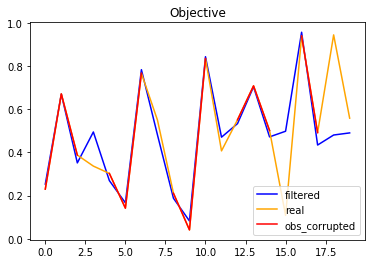

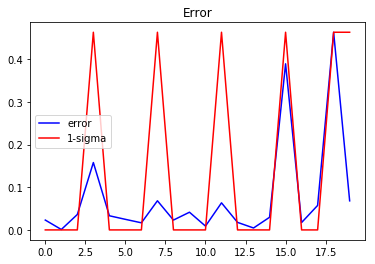

In [9]:
# plot
ind_sample=1
pyplot.title('Objective')
pyplot.plot(estimated_obj[ind_sample,:], color='blue', label='filtered')
pyplot.plot(objectives[ind_sample,:], color='orange', label='real')
pyplot.plot(observations_corrupted_mask[ind_sample,:], color='red', label='obs_corrupted')
pyplot.legend()
pyplot.show()

absError=abs(objectives-estimated_obj)

pyplot.title('Error')
pyplot.plot(absError[ind_sample,:], color='blue', label='error')
pyplot.plot(max(absError[ind_sample,:])*(1-sigma[ind_sample,:]), color='red', label='1-sigma')
pyplot.legend()
pyplot.show()

In [10]:
reward.info()

threshold: 3
cost: 0.1
number of measures: 4
mean error:
0.01183256222938411
error for measure: -0.02366512445876822
error history: [-0.0001878670676925386, -0.0057548420172474826, -0.031531643692703934, -0.009816689905466193, -0.013230166492789176, -0.010770357994005355, -0.14678338022723156, -0.03790857295361676, -0.03647351234995351, -0.05863222748668838, -0.0563128634725905, -0.03708048058433771, -0.033769928611018574, -0.03306265456053143, -0.03419092374011489, -0.03815277952910492, -0.03574669675636158, -0.034173548154075646, -0.04856326010230393, -0.033167526229211375, -0.02366512445876822]


In [13]:
print(sum(sigma[ind_sample,:]))
print(sigma[ind_sample,:])

14.0
[1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0.]


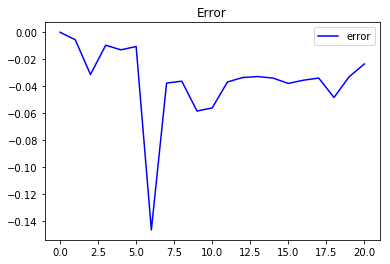

In [28]:
pyplot.title('Error')
pyplot.plot(reward._errors, color='blue', label='error')
pyplot.legend()
pyplot.show()

In [ ]:
reward._errors